In [1]:
# Установка необходимых библиотек
# !pip install numpy pandas matplotlib seaborn scikit-learn scipy surprise implicit

# Импорт основных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, ndcg_score
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Для более красивой визуализации
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("viridis")

In [2]:
# Загрузка данных MovieLens 100k
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(url, sep='\t', names=names)

# Загрузка информации о фильмах
movie_url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.item"
movie_names = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 
               'unknown', 'Action', 'Adventure', 'Animation', 'Children', 
               'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 
               'War', 'Western']
movies = pd.read_csv(movie_url, sep='|', names=movie_names, encoding='latin-1')

# Отображение первых строк данных
print("Данные о рейтингах:")
print(data.head())
print("\nРазмер данных:", data.shape)

print("\nДанные о фильмах:")
print(movies[['item_id', 'title', 'release_date']].head())

# Базовая статистика
print("\nСтатистика рейтингов:")
print(data['rating'].describe())

# Подготовка основных данных
user_item_matrix = pd.pivot_table(data, values='rating', 
                                 index='user_id', columns='item_id')

print("\nМатрица пользователь-элемент (размер):", user_item_matrix.shape)

Данные о рейтингах:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

Размер данных: (100000, 4)

Данные о фильмах:
   item_id              title release_date
0        1   Toy Story (1995)  01-Jan-1995
1        2   GoldenEye (1995)  01-Jan-1995
2        3  Four Rooms (1995)  01-Jan-1995
3        4  Get Shorty (1995)  01-Jan-1995
4        5     Copycat (1995)  01-Jan-1995

Статистика рейтингов:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Матрица пользователь-элемент (размер): (943, 1682)


In [3]:
# Разделение на обучающую и тестовую выборки
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print("Размер обучающей выборки:", train_data.shape)
print("Размер тестовой выборки:", test_data.shape)

# Создаем матрицы из обучающих данных
train_user_item_matrix = pd.pivot_table(train_data, values='rating', 
                                       index='user_id', columns='item_id')

Размер обучающей выборки: (80000, 4)
Размер тестовой выборки: (20000, 4)


# Визуализация распределения популярности

Топ-10 самых популярных фильмов:
   item_id  count                          title
0       50    583               Star Wars (1977)
1      258    509                 Contact (1997)
2      100    508                   Fargo (1996)
3      181    507      Return of the Jedi (1983)
4      294    485               Liar Liar (1997)
5      286    481    English Patient, The (1996)
6      288    478                  Scream (1996)
7        1    452               Toy Story (1995)
8      300    431           Air Force One (1997)
9      121    429  Independence Day (ID4) (1996)


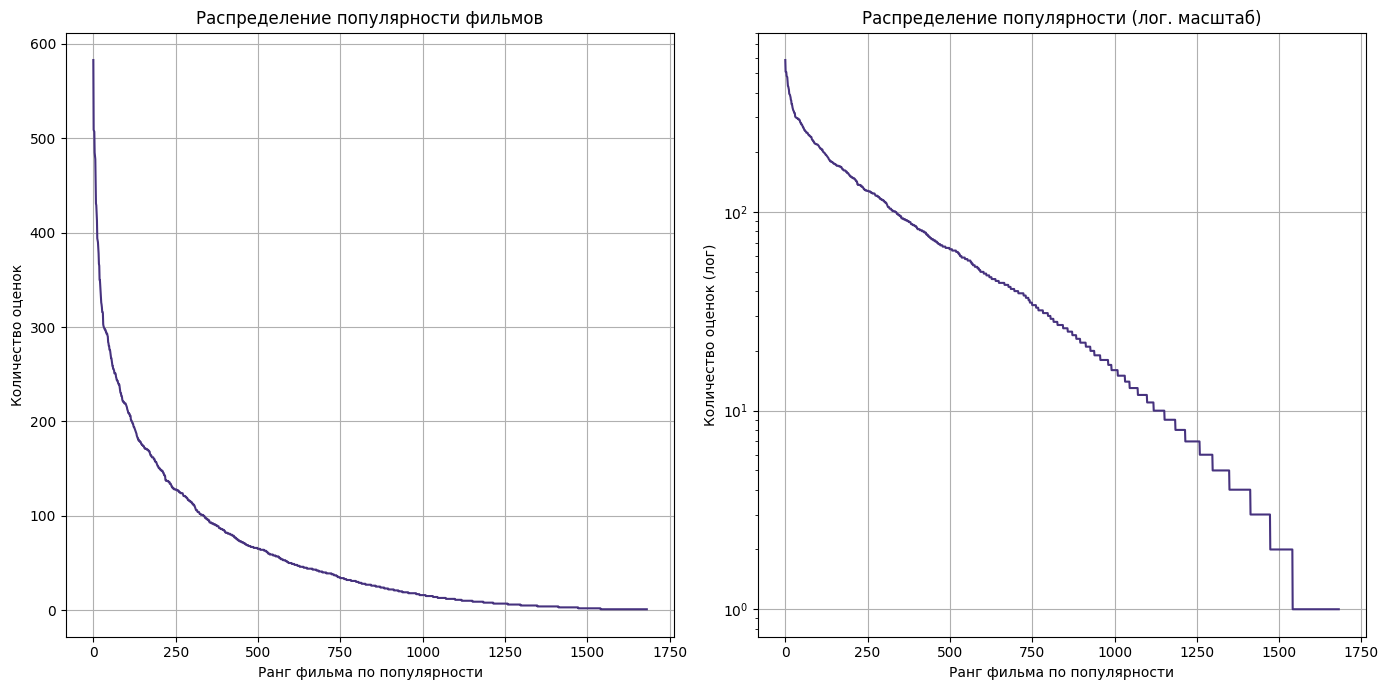

Коэффициент Джини для распределения популярности: 0.6290
Значение близкое к 1 указывает на высокое неравенство в распределении популярности.


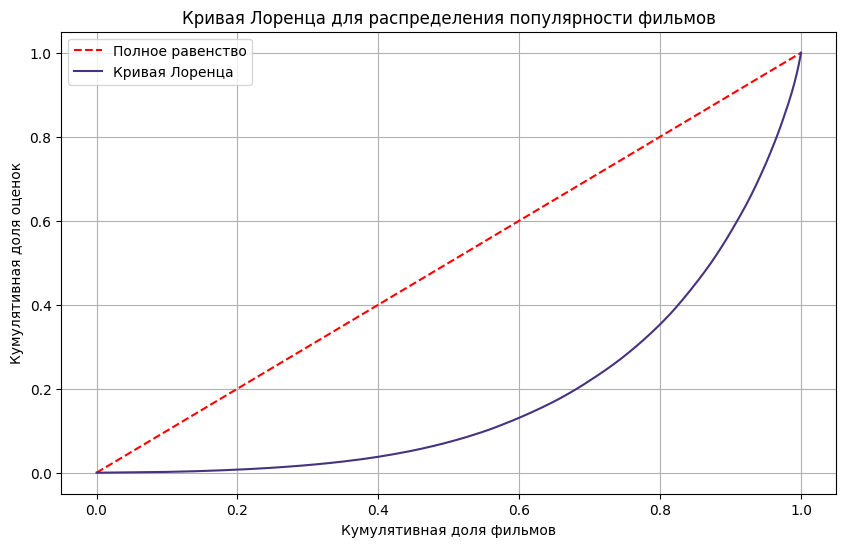

In [4]:
# Расчет популярности элементов
item_popularity = data.groupby('item_id').size()
item_popularity = item_popularity.sort_values(ascending=False)

# Создаем DataFrame с популярностью и названиями фильмов
popular_items = pd.DataFrame({
    'item_id': item_popularity.index,
    'count': item_popularity.values
})
popular_items = popular_items.merge(movies[['item_id', 'title']], on='item_id')

print("Топ-10 самых популярных фильмов:")
print(popular_items.head(10))

# Визуализация распределения популярности
plt.figure(figsize=(14, 7))

# График распределения популярности
plt.subplot(1, 2, 1)
plt.plot(range(len(item_popularity)), item_popularity.values)
plt.title('Распределение популярности фильмов')
plt.xlabel('Ранг фильма по популярности')
plt.ylabel('Количество оценок')
plt.grid(True)

# Логарифмический график для наглядности
plt.subplot(1, 2, 2)
plt.plot(range(len(item_popularity)), item_popularity.values)
plt.title('Распределение популярности (лог. масштаб)')
plt.xlabel('Ранг фильма по популярности')
plt.ylabel('Количество оценок (лог)')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

# Расчет коэффициента Джини для оценки неравенства популярности
def gini_coefficient(x):
    """Рассчитывает коэффициент Джини для распределения x"""
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / np.sum(x)) / n

gini = gini_coefficient(item_popularity.values)
print(f"Коэффициент Джини для распределения популярности: {gini:.4f}")
print("Значение близкое к 1 указывает на высокое неравенство в распределении популярности.")

# Визуализация кривой Лоренца
def lorenz_curve(x):
    """Рассчитывает кривую Лоренца для распределения x"""
    x_lorenz = np.sort(x)
    x_lorenz = np.cumsum(x_lorenz) / np.sum(x_lorenz)
    return np.insert(x_lorenz, 0, 0)

x_lorenz = lorenz_curve(item_popularity.values)
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'r--', label='Полное равенство')
plt.plot(np.linspace(0, 1, len(x_lorenz)), x_lorenz, label='Кривая Лоренца')
plt.title('Кривая Лоренца для распределения популярности фильмов')
plt.xlabel('Кумулятивная доля фильмов')
plt.ylabel('Кумулятивная доля оценок')
plt.legend()
plt.grid(True)
plt.show()

# Анализ влияния популярности на рейтинги

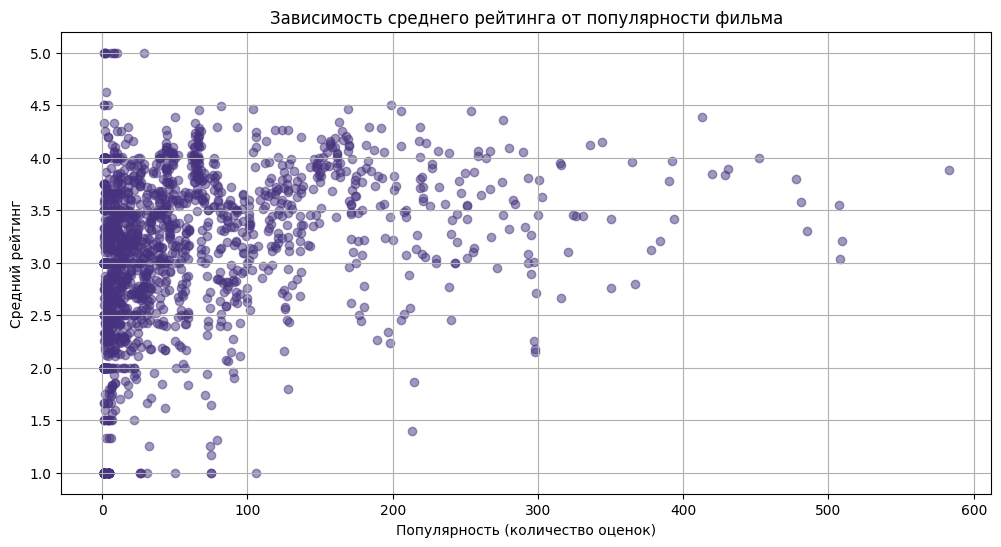

Корреляция Спирмена между популярностью и средним рейтингом: 0.3964
p-значение: 0.0000

Статистика по квартилям популярности:
                          avg_rating  count
popularity_quartile                        
Q1 (Наименее популярные)    2.598420    423
Q2                          3.026346    432
Q3                          3.273101    411
Q4 (Наиболее популярные)    3.418629    416


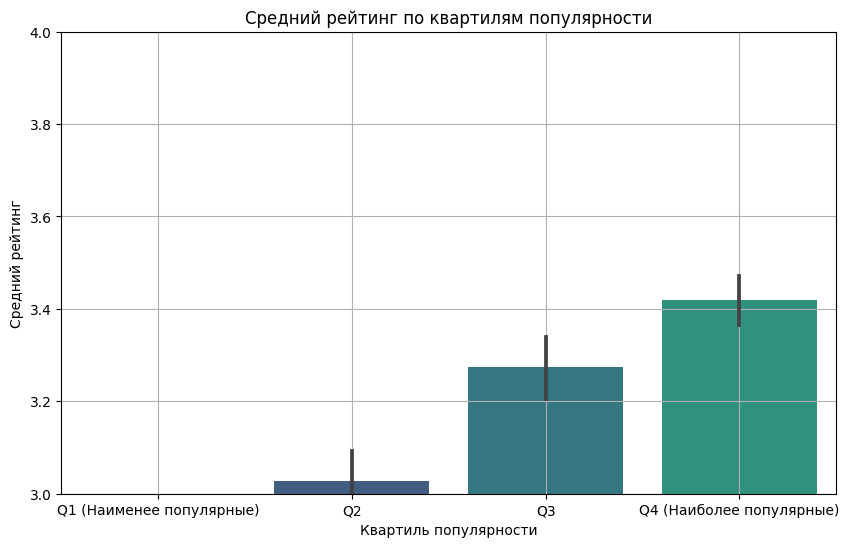

In [5]:
# Расчет средних рейтингов для каждого фильма
item_avg_rating = data.groupby('item_id')['rating'].mean()

# Объединение данных о популярности и средних рейтингах
popularity_rating = pd.DataFrame({
    'item_id': item_popularity.index,
    'popularity': item_popularity.values,
    'avg_rating': item_avg_rating.values
})

# Визуализация зависимости рейтинга от популярности
plt.figure(figsize=(12, 6))
plt.scatter(popularity_rating['popularity'], popularity_rating['avg_rating'], alpha=0.5)
plt.title('Зависимость среднего рейтинга от популярности фильма')
plt.xlabel('Популярность (количество оценок)')
plt.ylabel('Средний рейтинг')
plt.grid(True)
plt.show()

# Расчет корреляции Спирмена между популярностью и средним рейтингом
correlation, p_value = stats.spearmanr(popularity_rating['popularity'], 
                                      popularity_rating['avg_rating'])
print(f"Корреляция Спирмена между популярностью и средним рейтингом: {correlation:.4f}")
print(f"p-значение: {p_value:.4f}")

# Разделение фильмов на квартили по популярности
popularity_rating['popularity_quartile'] = pd.qcut(popularity_rating['popularity'], 4, 
                                                 labels=['Q1 (Наименее популярные)', 
                                                        'Q2', 'Q3', 
                                                        'Q4 (Наиболее популярные)'])

# Статистика по квартилям
quartile_stats = popularity_rating.groupby('popularity_quartile').agg(
    avg_rating=('avg_rating', 'mean'),
    count=('item_id', 'count')
)
print("\nСтатистика по квартилям популярности:")
print(quartile_stats)

# Визуализация средних рейтингов по квартилям
plt.figure(figsize=(10, 6))
sns.barplot(x='popularity_quartile', y='avg_rating', data=popularity_rating)
plt.title('Средний рейтинг по квартилям популярности')
plt.xlabel('Квартиль популярности')
plt.ylabel('Средний рейтинг')
plt.ylim(3.0, 4.0)
plt.grid(True)
plt.show()

# Часть 3: Реализация базового рекомендателя и анализ его смещенности
## Реализация SVD-рекомендера

In [6]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split as surprise_split

# Подготовка данных в формате для библиотеки Surprise
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

# Разделение данных
surprise_trainset, surprise_testset = surprise_split(surprise_data, test_size=0.2, random_state=42)

# Обучение модели SVD
svd_model = SVD(n_factors=100, n_epochs=20, random_state=42)
svd_model.fit(surprise_trainset)

# Оценка модели
predictions = svd_model.test(surprise_testset)
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse:.4f}")

# Создаем функцию для получения рекомендаций
def get_top_n_recommendations(model, user_id, n=10, item_list=None):
    """
    Получает топ-N рекомендаций для пользователя
    
    Параметры:
    - model: обученная модель Surprise
    - user_id: ID пользователя
    - n: количество рекомендаций
    - item_list: список ID элементов для оценки (если None, используются все элементы)
    
    Возвращает:
    - список кортежей (item_id, predicted_rating)
    """
    if item_list is None:
        # Используем все уникальные элементы из данных
        item_list = data['item_id'].unique()
    
    # Получаем предсказания для всех элементов
    predictions = [model.predict(user_id, item_id) for item_id in item_list]
    
    # Сортируем предсказания и возвращаем топ-N
    predictions.sort(key=lambda x: x.est, reverse=True)
    return [(pred.iid, pred.est) for pred in predictions[:n]]

# Получаем рекомендации для первых 5 пользователей
for user_id in range(1, 6):
    recommendations = get_top_n_recommendations(svd_model, user_id, n=5)
    rec_df = pd.DataFrame(recommendations, columns=['item_id', 'predicted_rating'])
    rec_df = rec_df.merge(movies[['item_id', 'title']], on='item_id')
    
    print(f"\nТоп-5 рекомендаций для пользователя {user_id}:")
    print(rec_df[['title', 'predicted_rating']])

RMSE: 0.9352
RMSE: 0.9352

Топ-5 рекомендаций для пользователя 1:
                                               title  predicted_rating
0                                   Star Wars (1977)          5.000000
1                    Empire Strikes Back, The (1980)          4.966800
2  Dr. Strangelove or: How I Learned to Stop Worr...          4.937230
3             One Flew Over the Cuckoo's Nest (1975)          4.936512
4                                 Rear Window (1954)          4.925143

Топ-5 рекомендаций для пользователя 2:
                            title  predicted_rating
0           Close Shave, A (1995)          4.768347
1  Raiders of the Lost Ark (1981)          4.706256
2              Rear Window (1954)          4.651106
3       Lawrence of Arabia (1962)          4.611713
4                Apt Pupil (1998)          4.597132

Топ-5 рекомендаций для пользователя 3:
                          title  predicted_rating
0              Star Wars (1977)          4.094319
1         Godfat

# Анализ смещенности рекомендаций

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Топ-10 наиболее часто рекомендуемых фильмов:
                              title  rec_count  popularity  avg_rating
0             Close Shave, A (1995)         66         112    3.536913
1                 Casablanca (1942)         60         243    3.000000
2           Schindler's List (1993)         58         298    2.153846
3  Shawshank Redemption, The (1994)         55         283    3.601504
4        Wrong Trousers, The (1993)         50         118    3.589744
5             Third Man, The (1949)         50          72    2.312500
6                  Star Wars (1977)         37         583    3.878319
7        Usual Suspects, The (1995)         35         267    3.704698
8               12 Angry Men (1957)         25         125    3.712121
9    Raiders of the Lost Ark (1981)         25         420    3.847458

Коэффициент Джини для распределения рекомендаций: 0.6547


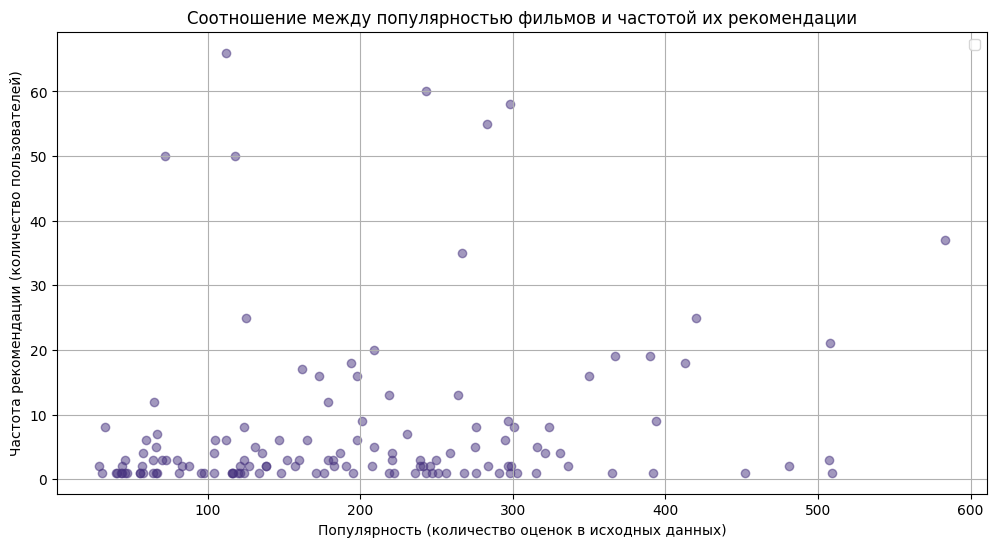

Корреляция Спирмена между популярностью и частотой рекомендации: 0.2386
p-значение: 0.0055

Распределение рекомендаций по квинтилям популярности:
                          avg_rec_count  sum_rec_count  count  percentage
popularity_quintile                                                      
Q1 (Наименее популярные)       4.555556            123     27        12.3
Q2                             7.250000            203     28        20.3
Q3                             6.653846            173     26        17.3
Q4                             8.576923            223     26        22.3
Q5 (Наиболее популярные)      10.296296            278     27        27.8


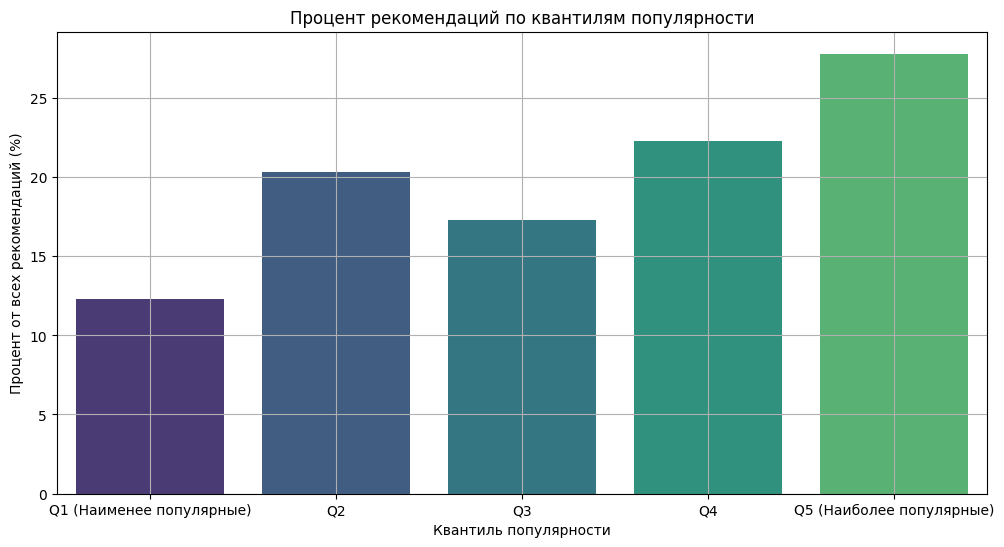

In [10]:
# Функция для генерации рекомендаций для всех пользователей
def generate_recommendations_for_all_users(model, user_list, n=10, item_list=None):
    """
    Генерирует рекомендации для всех пользователей в списке
    
    Возвращает:
    - словарь {user_id: list of recommended item_ids}
    """
    recommendations = {}
    for user_id in user_list:
        user_recs = get_top_n_recommendations(model, user_id, n=n, item_list=item_list)
        recommendations[user_id] = [item_id for item_id, _ in user_recs]
    return recommendations

# Генерация рекомендаций для первых 100 пользователей
users_sample = list(range(1, 101))
all_recommendations = generate_recommendations_for_all_users(svd_model, users_sample, n=10)

# Анализ популярности рекомендуемых элементов
recommended_items = [item for user_recs in all_recommendations.values() for item in user_recs]
recommended_counts = Counter(recommended_items)

# Создаем DataFrame для анализа
rec_popularity = pd.DataFrame({
    'item_id': list(recommended_counts.keys()),
    'rec_count': list(recommended_counts.values())
}).sort_values('rec_count', ascending=False)

# Объединяем с данными о фильмах и их популярности
rec_analysis = rec_popularity.merge(
    popularity_rating[['item_id', 'popularity', 'avg_rating']], 
    on='item_id'
).merge(
    movies[['item_id', 'title']], 
    on='item_id'
)

print("Топ-10 наиболее часто рекомендуемых фильмов:")
print(rec_analysis[['title', 'rec_count', 'popularity', 'avg_rating']].head(10))

# Расчет коэффициента Джини для распределения рекомендаций
rec_gini = gini_coefficient(rec_analysis['rec_count'].values)
print(f"\nКоэффициент Джини для распределения рекомендаций: {rec_gini:.4f}")

# Визуализация соотношения популярности фильмов и частоты их рекомендации
plt.figure(figsize=(12, 6))
plt.scatter(rec_analysis['popularity'], rec_analysis['rec_count'], alpha=0.5)
plt.title('Соотношение между популярностью фильмов и частотой их рекомендации')
plt.xlabel('Популярность (количество оценок в исходных данных)')
plt.ylabel('Частота рекомендации (количество пользователей)')
plt.grid(True)

plt.legend()
plt.show()

# Расчет корреляции Спирмена между популярностью и частотой рекомендации
corr, p_value = stats.spearmanr(rec_analysis['popularity'], rec_analysis['rec_count'])
print(f"Корреляция Спирмена между популярностью и частотой рекомендации: {corr:.4f}")
print(f"p-значение: {p_value:.4f}")

# Разделение фильмов на 5 групп по популярности для более детального анализа
rec_analysis['popularity_quintile'] = pd.qcut(rec_analysis['popularity'], 5, 
                                            labels=['Q1 (Наименее популярные)', 
                                                   'Q2', 'Q3', 'Q4', 
                                                   'Q5 (Наиболее популярные)'])

# Анализ распределения рекомендаций по группам популярности
quintile_stats = rec_analysis.groupby('popularity_quintile').agg(
    avg_rec_count=('rec_count', 'mean'),
    sum_rec_count=('rec_count', 'sum'),
    count=('item_id', 'count')
)
quintile_stats['percentage'] = quintile_stats['sum_rec_count'] / quintile_stats['sum_rec_count'].sum() * 100

print("\nРаспределение рекомендаций по квинтилям популярности:")
print(quintile_stats)

# Визуализация распределения рекомендаций по группам популярности
plt.figure(figsize=(12, 6))
sns.barplot(x='popularity_quintile', y='percentage', data=quintile_stats.reset_index())
plt.title('Процент рекомендаций по квантилям популярности')
plt.xlabel('Квантиль популярности')
plt.ylabel('Процент от всех рекомендаций (%)')
plt.grid(True)
plt.show()

# Часть 4: Устранение популярностного смещения


Рекомендации для пользователя 1:
Стандартные рекомендации:
                                               title  predicted_rating
0                                   Star Wars (1977)          5.000000
1                    Empire Strikes Back, The (1980)          4.966800
2  Dr. Strangelove or: How I Learned to Stop Worr...          4.937230
3             One Flew Over the Cuckoo's Nest (1975)          4.936512
4                                 Rear Window (1954)          4.925143

Рекомендации с коррекцией популярности:
                                               title  adjusted_score  \
0  Wallace & Gromit: The Best of Aardman Animatio...        4.451872   
1                                 Hoop Dreams (1994)        4.430937   
2                              Third Man, The (1949)        4.391503   
3                                Delicatessen (1991)        4.295921   
4                         Wrong Trousers, The (1993)        4.252760   

   original_score  
0        4.719471  


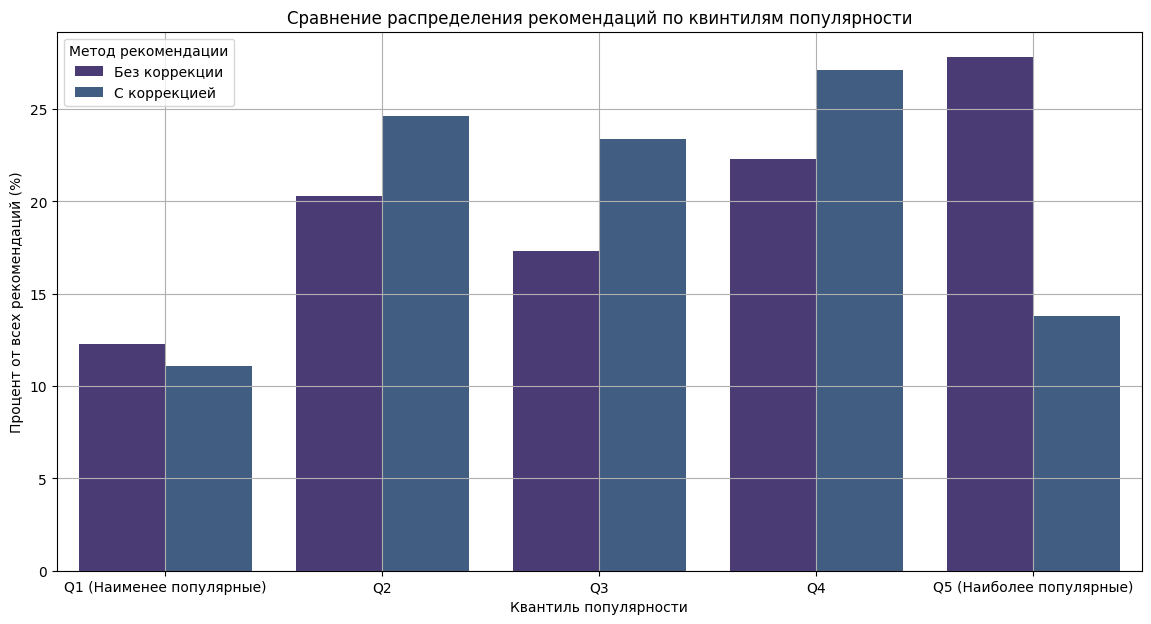

In [11]:
# Реализация модифицированного рекомендателя с корректировкой популярности
def get_popularity_corrected_recommendations(model, user_id, item_popularity, alpha=0.5, n=10, item_list=None):
    """
    Получает рекомендации с коррекцией популярностного смещения
    
    Параметры:
    - model: обученная модель
    - user_id: ID пользователя
    - item_popularity: Series с популярностью элементов
    - alpha: параметр регуляризации популярности (0 - нет коррекции, 1 - максимальная коррекция)
    - n: количество рекомендаций
    
    Возвращает:
    - список кортежей (item_id, adjusted_score)
    """
    if item_list is None:
        # Используем все уникальные элементы из данных
        item_list = data['item_id'].unique()
    
    # Получаем предсказания для всех элементов
    predictions = []
    for item_id in item_list:
        # Предсказанный рейтинг
        pred = model.predict(user_id, item_id).est
        
        # Популярность элемента (если элемента нет в item_popularity, устанавливаем минимальную популярность)
        pop = item_popularity.get(item_id, min(item_popularity.values()))
        
        # Нормализация популярности (от 0 до 1)
        pop_norm = (pop - min(item_popularity.values())) / (max(item_popularity.values()) - min(item_popularity.values()))
        
        # Скорректированный скор (понижаем релевантность популярных элементов)
        adjusted_score = pred * (1 - alpha * pop_norm)
        
        predictions.append((item_id, adjusted_score, pred))
    
    # Сортировка по скорректированному скору
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]

# Преобразование популярности в словарь для быстрого доступа
popularity_dict = item_popularity.to_dict()

# Пример использования корректированных рекомендаций
for user_id in range(1, 6):
    # Получаем обычные рекомендации
    normal_recs = get_top_n_recommendations(svd_model, user_id, n=5)
    normal_df = pd.DataFrame(normal_recs, columns=['item_id', 'predicted_rating'])
    normal_df = normal_df.merge(movies[['item_id', 'title']], on='item_id')
    
    # Получаем скорректированные рекомендации
    corrected_recs = get_popularity_corrected_recommendations(
        svd_model, user_id, popularity_dict, alpha=0.5, n=5
    )
    corrected_df = pd.DataFrame([(i[0], i[1], i[2]) for i in corrected_recs], 
                              columns=['item_id', 'adjusted_score', 'original_score'])
    corrected_df = corrected_df.merge(movies[['item_id', 'title']], on='item_id')
    
    print(f"\nРекомендации для пользователя {user_id}:")
    print("Стандартные рекомендации:")
    print(normal_df[['title', 'predicted_rating']])
    print("\nРекомендации с коррекцией популярности:")
    print(corrected_df[['title', 'adjusted_score', 'original_score']])

# Анализ скорректированных рекомендаций для всех пользователей
def generate_corrected_recommendations_for_all_users(model, user_list, item_popularity, alpha=0.5, n=10):
    """
    Генерирует скорректированные рекомендации для всех пользователей в списке
    """
    recommendations = {}
    for user_id in user_list:
        user_recs = get_popularity_corrected_recommendations(
            model, user_id, item_popularity, alpha=alpha, n=n
        )
        recommendations[user_id] = [item_id for item_id, _, _ in user_recs]
    return recommendations

# Генерация скорректированных рекомендаций
corrected_recommendations = generate_corrected_recommendations_for_all_users(
    svd_model, users_sample, popularity_dict, alpha=0.5, n=10
)

# Анализ популярности скорректированных рекомендаций
corrected_items = [item for user_recs in corrected_recommendations.values() for item in user_recs]
corrected_counts = Counter(corrected_items)

# Создаем DataFrame для анализа
corrected_rec_popularity = pd.DataFrame({
    'item_id': list(corrected_counts.keys()),
    'rec_count': list(corrected_counts.values())
}).sort_values('rec_count', ascending=False)

# Объединяем с данными о фильмах и их популярности
corrected_analysis = corrected_rec_popularity.merge(
    popularity_rating[['item_id', 'popularity', 'avg_rating']], 
    on='item_id'
).merge(
    movies[['item_id', 'title']], 
    on='item_id'
)

print("\nТоп-10 наиболее часто рекомендуемых фильмов после коррекции:")
print(corrected_analysis[['title', 'rec_count', 'popularity', 'avg_rating']].head(10))

# Расчет коэффициента Джини для распределения скорректированных рекомендаций
corrected_gini = gini_coefficient(corrected_analysis['rec_count'].values)
print(f"\nКоэффициент Джини для распределения скорректированных рекомендаций: {corrected_gini:.4f}")
print(f"Коэффициент Джини для распределения обычных рекомендаций: {rec_gini:.4f}")

# Сравнительная визуализация распределения рекомендаций
# Разделение фильмов на 5 групп по популярности
corrected_analysis['popularity_quintile'] = pd.qcut(corrected_analysis['popularity'], 5, 
                                                  labels=['Q1 (Наименее популярные)', 
                                                         'Q2', 'Q3', 'Q4', 
                                                         'Q5 (Наиболее популярные)'])

# Анализ распределения скорректированных рекомендаций по группам популярности
corrected_quintile_stats = corrected_analysis.groupby('popularity_quintile').agg(
    avg_rec_count=('rec_count', 'mean'),
    sum_rec_count=('rec_count', 'sum'),
    count=('item_id', 'count')
)
corrected_quintile_stats['percentage'] = corrected_quintile_stats['sum_rec_count'] / corrected_quintile_stats['sum_rec_count'].sum() * 100

# Создаем данные для сравнительной визуализации
comparison_data = pd.DataFrame({
    'popularity_quintile': quintile_stats.index.tolist() + corrected_quintile_stats.index.tolist(),
    'percentage': quintile_stats['percentage'].tolist() + corrected_quintile_stats['percentage'].tolist(),
    'method': ['Без коррекции'] * 5 + ['С коррекцией'] * 5
})

# Визуализация сравнения
plt.figure(figsize=(14, 7))
sns.barplot(x='popularity_quintile', y='percentage', hue='method', data=comparison_data)
plt.title('Сравнение распределения рекомендаций по квинтилям популярности')
plt.xlabel('Квантиль популярности')
plt.ylabel('Процент от всех рекомендаций (%)')
plt.grid(True)
plt.legend(title='Метод рекомендации')
plt.show()

# Часть 5: Анализ позиционного смещения
## Симуляция позиционного смещения

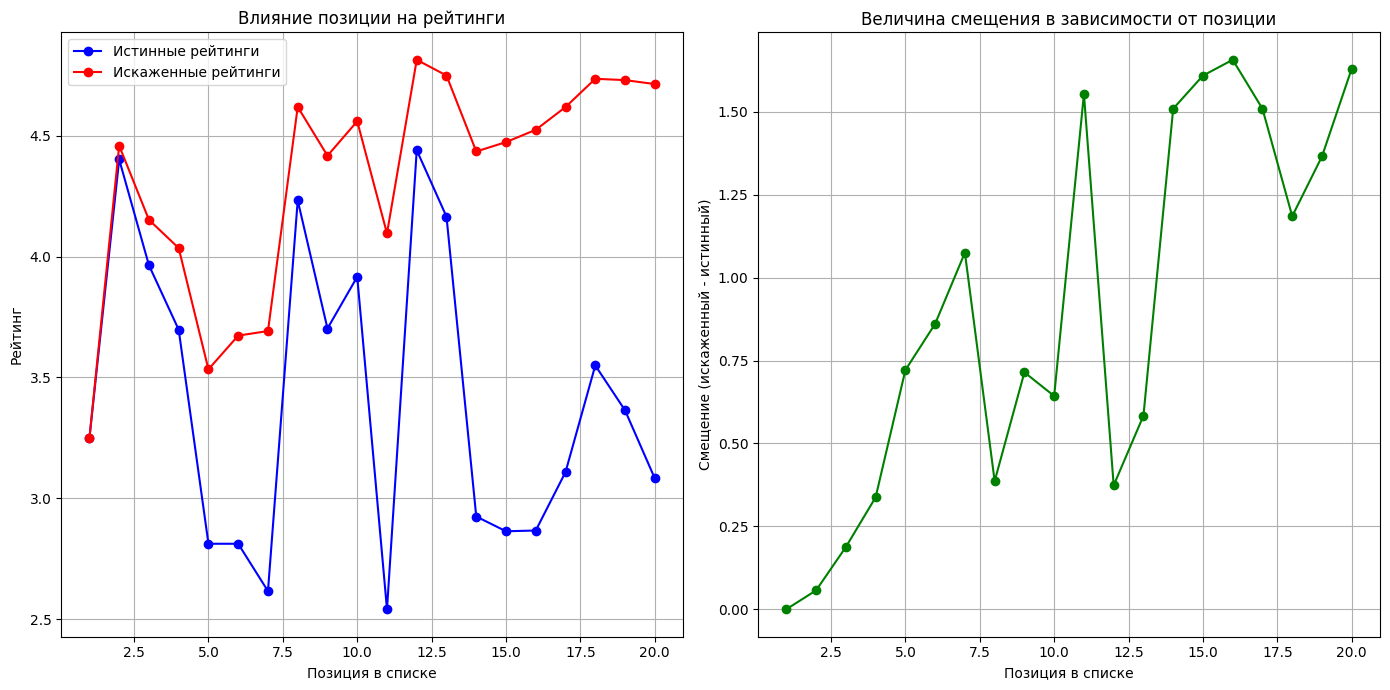

Результаты симуляции позиционного смещения:
    Position  True Rating  Biased Rating      Bias
0          1     3.249080       3.249080  0.000000
1          2     4.401429       4.458390  0.056962
2          3     3.963988       4.151785  0.187797
3          4     3.697317       4.034949  0.337632
4          5     2.812037       3.533365  0.721327
5          6     2.811989       3.672904  0.860915
6          7     2.616167       3.691725  1.075558
7          8     4.232352       4.618797  0.386445
8          9     3.702230       4.416874  0.714644
9         10     3.916145       4.559338  0.643192
10        11     2.541169       4.095447  1.554278
11        12     4.439820       4.813532  0.373712
12        13     4.164885       4.748468  0.583583
13        14     2.924678       4.434409  1.509731
14        15     2.863650       4.473183  1.609533
15        16     2.866809       4.524021  1.657212
16        17     3.108484       4.618110  1.509625
17        18     3.549513       4.7350

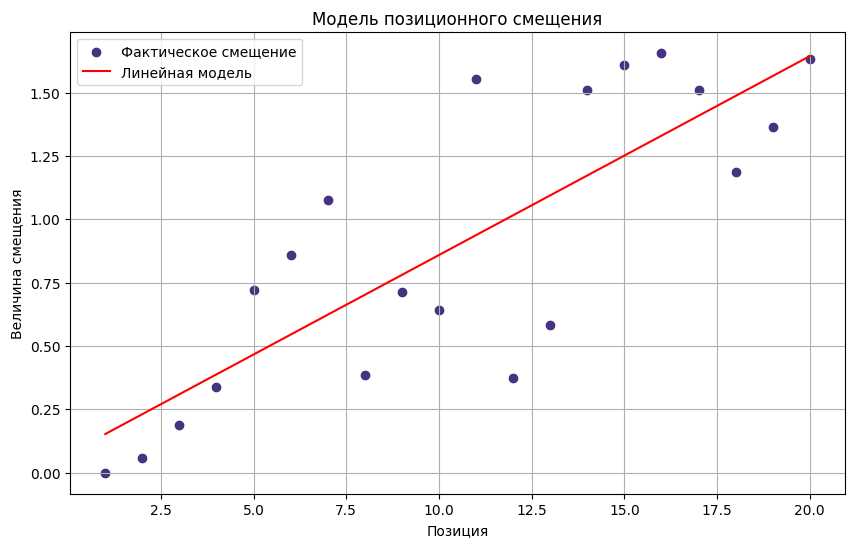

In [12]:
# Функция симуляции позиционного смещения
def simulate_position_bias(ratings, positions, bias_function=None):
    """
    Симулирует искажение рейтингов из-за позиционного смещения
    
    Параметры:
    - ratings: исходные рейтинги (истинные предпочтения)
    - positions: позиции элементов в интерфейсе
    - bias_function: функция, которая определяет смещение в зависимости от позиции
                    (если None, используется экспоненциальное затухание)
    
    Возвращает:
    - искаженные рейтинги
    """
    if bias_function is None:
        # По умолчанию используем экспоненциальное затухание
        # Первая позиция имеет вес 1.0, затем вес убывает
        def bias_function(position):
            return np.exp(-0.1 * (position - 1))
    
    # Применяем смещение к рейтингам
    biased_ratings = []
    for rating, position in zip(ratings, positions):
        # Чем выше позиция (меньше номер), тем сильнее искажение в положительную сторону
        bias = bias_function(position)
        # Искаженный рейтинг - это комбинация истинного рейтинга и смещения
        # Здесь мы используем простую модель, где истинный рейтинг немного притягивается
        # к максимальному значению пропорционально весу позиции
        biased_rating = rating + (5 - rating) * (1 - bias)
        biased_ratings.append(biased_rating)
    
    return biased_ratings

# Создадим симуляцию интерфейса с позиционным смещением
np.random.seed(42)
# Предположим, что у нас есть 20 фильмов с истинными рейтингами
true_ratings = np.random.uniform(2.5, 4.5, 20)
# Фильмы представлены в определенном порядке
positions = list(range(1, 21))

# Симулируем искаженные рейтинги
biased_ratings = simulate_position_bias(true_ratings, positions)

# Визуализация
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(positions, true_ratings, 'bo-', label='Истинные рейтинги')
plt.plot(positions, biased_ratings, 'ro-', label='Искаженные рейтинги')
plt.title('Влияние позиции на рейтинги')
plt.xlabel('Позиция в списке')
plt.ylabel('Рейтинг')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(positions, np.array(biased_ratings) - np.array(true_ratings), 'go-')
plt.title('Величина смещения в зависимости от позиции')
plt.xlabel('Позиция в списке')
plt.ylabel('Смещение (искаженный - истинный)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Таблица с результатами
results_df = pd.DataFrame({
    'Position': positions,
    'True Rating': true_ratings,
    'Biased Rating': biased_ratings,
    'Bias': np.array(biased_ratings) - np.array(true_ratings)
})
print("Результаты симуляции позиционного смещения:")
print(results_df)

# Регрессионный анализ для оценки влияния позиции на смещение
from sklearn.linear_model import LinearRegression

X = np.array(positions).reshape(-1, 1)
y = np.array(biased_ratings) - np.array(true_ratings)

model = LinearRegression()
model.fit(X, y)

print(f"\nКоэффициент регрессии: {model.coef_[0]:.4f}")
print(f"Свободный член: {model.intercept_:.4f}")
print(f"R-squared: {model.score(X, y):.4f}")

# Предсказание смещения на основе позиции
y_pred = model.predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(positions, y, label='Фактическое смещение')
plt.plot(positions, y_pred, 'r-', label='Линейная модель')
plt.title('Модель позиционного смещения')
plt.xlabel('Позиция')
plt.ylabel('Величина смещения')
plt.legend()
plt.grid(True)
plt.show()

## Моделирование алгоритма коррекции позиционного смещения


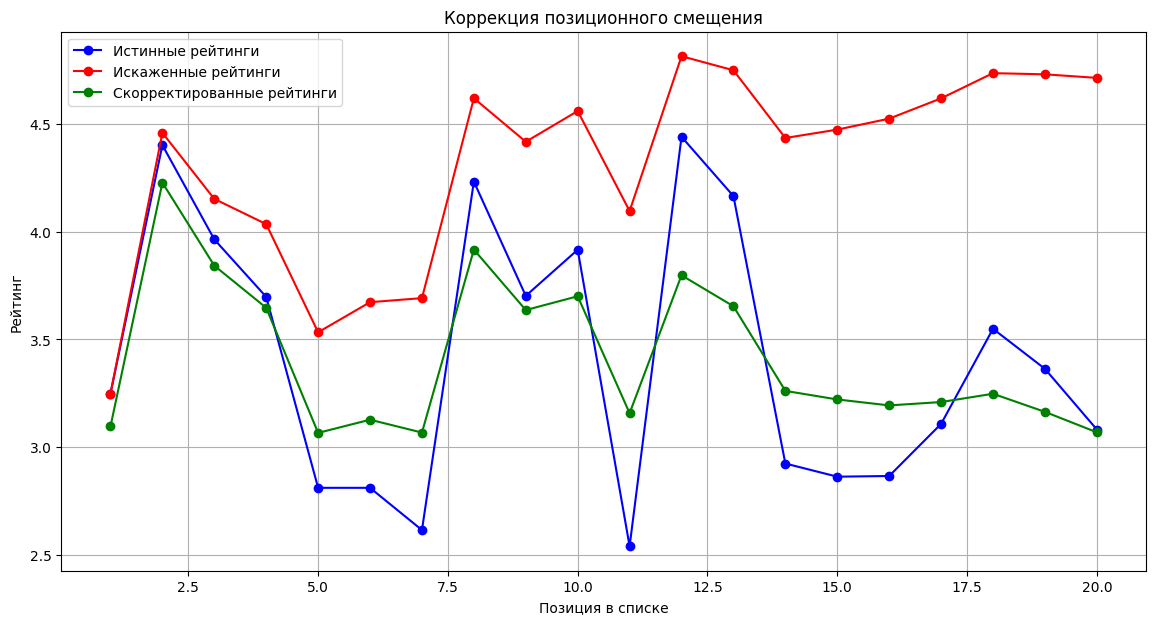

MAE для искаженных рейтингов: 0.8982
MAE для скорректированных рейтингов: 0.2763
Улучшение точности: 69.24%

Результаты коррекции позиционного смещения:
    Position  True Rating  Biased Rating  Corrected Rating      Bias  \
0          1     3.249080       3.249080          3.096442  0.000000   
1          2     4.401429       4.458390          4.227271  0.056962   
2          3     3.963988       4.151785          3.842186  0.187797   
3          4     3.697317       4.034949          3.646869  0.337632   
4          5     2.812037       3.533365          3.066804  0.721327   
5          6     2.811989       3.672904          3.127864  0.860915   
6          7     2.616167       3.691725          3.068204  1.075558   
7          8     4.232352       4.618797          3.916796  0.386445   
8          9     3.702230       4.416874          3.636392  0.714644   
9         10     3.916145       4.559338          3.700375  0.643192   
10        11     2.541169       4.095447          3.158

In [13]:
# Функция для коррекции позиционного смещения на основе модели
def correct_position_bias(biased_ratings, positions, bias_model):
    """
    Корректирует рейтинги, искаженные позиционным смещением
    
    Параметры:
    - biased_ratings: искаженные рейтинги
    - positions: позиции элементов
    - bias_model: модель, предсказывающая смещение на основе позиции
    
    Возвращает:
    - скорректированные рейтинги
    """
    # Предсказываем смещение для каждой позиции
    predicted_biases = bias_model.predict(np.array(positions).reshape(-1, 1))
    
    # Вычитаем предсказанное смещение из искаженных рейтингов
    corrected_ratings = np.array(biased_ratings) - predicted_biases
    
    # Ограничиваем рейтинги допустимым диапазоном (1-5)
    corrected_ratings = np.clip(corrected_ratings, 1, 5)
    
    return corrected_ratings

# Корректируем искаженные рейтинги
corrected_ratings = correct_position_bias(biased_ratings, positions, model)

# Визуализация результатов коррекции
plt.figure(figsize=(14, 7))

plt.plot(positions, true_ratings, 'bo-', label='Истинные рейтинги')
plt.plot(positions, biased_ratings, 'ro-', label='Искаженные рейтинги')
plt.plot(positions, corrected_ratings, 'go-', label='Скорректированные рейтинги')
plt.title('Коррекция позиционного смещения')
plt.xlabel('Позиция в списке')
plt.ylabel('Рейтинг')
plt.grid(True)
plt.legend()
plt.show()

# Оценка точности коррекции
mae_biased = np.mean(np.abs(np.array(biased_ratings) - np.array(true_ratings)))
mae_corrected = np.mean(np.abs(np.array(corrected_ratings) - np.array(true_ratings)))

print(f"MAE для искаженных рейтингов: {mae_biased:.4f}")
print(f"MAE для скорректированных рейтингов: {mae_corrected:.4f}")
print(f"Улучшение точности: {(1 - mae_corrected/mae_biased)*100:.2f}%")

# Таблица с результатами
correction_results = pd.DataFrame({
    'Position': positions,
    'True Rating': true_ratings,
    'Biased Rating': biased_ratings,
    'Corrected Rating': corrected_ratings,
    'Bias': np.array(biased_ratings) - np.array(true_ratings),
    'Residual Error': np.array(corrected_ratings) - np.array(true_ratings)
})
print("\nРезультаты коррекции позиционного смещения:")
print(correction_results)